In [1]:

import glob
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import torch

from copy import deepcopy
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
from typing import Tuple, Optional, List
from tqdm import tqdm


# Torch imports
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision

from PIL import Image
from torch import nn
from torchvision import transforms
from torchvision.datasets.folder import default_loader as loader 

# labml imports
from labml import lab, tracker, experiment, monit
from labml.configs import BaseConfigs, option
from labml_helpers.device import DeviceConfigs
from labml_nn.diffusion.ddpm import DenoiseDiffusion
from labml_nn.diffusion.ddpm.unet import UNet
# from labml_nn.diffusion.ddpm.experiment import Configs
from labml_nn.diffusion.ddpm.utils import gather

# Diffusion for Dynamics Model
This notebook is for using diffusion models to sample the next state in each step
Main steps will be as follows: 
1. Train a `eps_model` to predict the noise in the diffusion model
2. Also there will be an `MSE` loss between the generated position and the next position

## Model Implementations

In [2]:
class EpsModel(nn.Module): # It will get 2 values for position and 1 binary flag to indicate if the input is a dog or a box
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, hidden_shape),
            nn.ReLU(),
            nn.Linear(hidden_shape, hidden_shape),
            nn.ReLU(),
            nn.Linear(hidden_shape, hidden_shape),
            nn.ReLU(),
            nn.Linear(hidden_shape, output_shape) # Output shape will be two values (x and y)
        )

    def forward(self, xt, t, x0, a): # x: data, t: timestep of diffusion, a: action
        # Add another dimension to t
        t = t.reshape(xt.shape) # They technically should have the same shape - noise timestepi
        a = a.reshape(xt.shape) # For some reason the inputs have 1 dimension without reshape
        out = torch.cat((xt,t,x0,a), dim=-1)
        return self.model(out)

# Optimizer will be used to train this model

In [3]:
class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps # Number of steps to noise and denoise the data
        self.sigma2 = self.beta # This is actually 1 - self.alpha as well 

    def gather(self, consts: torch.Tensor, t: torch.Tensor):
        c = consts.gather(-1, t)
        return c.reshape(-1, 1)

    # q(xt|x0,t) - gives noised xts for different ts - noises them starting from completely clean data
    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean = self.gather(self.alpha_bar, t) ** 0.5 * x0 # This multiplication here makes everything dirty 
        var = 1 - self.gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        if eps is None:
            eps = torch.randn_like(x0)
        mean, var = self.q_xt_x0(x0, t)
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor, x0: torch.Tensor, a: torch.Tensor):
        eps_theta = self.eps_model(xt, t, x0, a) # This will for sure be complete noise
        alpha_bar = self.gather(self.alpha_bar, t)
        alpha = self.gather(self.alpha, t)
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        var = self.gather(self.sigma2, t) # (1 - self.alpha)

        eps = torch.randn(xt.shape, device=xt.device)
        # Torch clamp is necessary in order not to have a super small std
        return mean + (var ** 5.) * eps

    # x0 and xnext0 are supposed to be clean tensors
    def loss(self, x0: torch.Tensor, xnext0: torch.Tensor, a: torch.Tensor, noise: Optional[torch.Tensor] = None):
        batch_size = xnext0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=xnext0.device, dtype=torch.long)

        if noise is None:
            noise = torch.randn_like(xnext0)

        # Noise the clean next state
        xnextt = self.q_sample(xnext0, t, eps=noise)
        # Learn the noise applied to xnext0 
        eps_theta = self.eps_model(xnextt, t, x0, a) # Prediction of the next state should have the current state
        return F.mse_loss(noise, eps_theta)

        
        

## Diffusion with Mock Data
We will do these things with the mock data first

### Mock Data Creation
There will be mock first and next data.


They will be two gaussian distributions with two different means

In [4]:
# Method to plot gaussian distribution with the given data
# It will first find the mean and std of the given data
# then it will plot it
def plot_gaus_dist(x, ax, label):
    traj_len = len(x)

    mean = x.mean()
    std = x.std()

    lin_range = np.linspace(mean-std*2, mean+std*2, traj_len)
    ax.plot(lin_range, stats.norm.pdf(lin_range, mean, std), label=label)
    ax.legend()

def plot_data(x, ax, label):
    traj_len = len(x)
    ax.plot(x, np.random.rand(traj_len), 'o', label=label)
    ax.legend()


In [5]:
class MockDist(data.Dataset):
    def __init__(self, curr_mean, curr_std, act_mean, act_std, dataset_size):
        # self.curr_mean = curr_mean 
        # self.curr_std = curr_std 
        # self.next_mean = next_mean 
        # self.next_std = next_std 
        self.dataset_size = dataset_size
        self.curr_data = np.random.normal(curr_mean, curr_std, dataset_size)
        self.action_data = np.random.normal(act_mean, act_std, dataset_size)
        random_noise = np.random.normal(0, 0.1, dataset_size)
        self.next_data = self.curr_data + self.action_data + random_noise
        # self.next_data = np.random.normal(next_mean, next_std, dataset_size)

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, index):
        return torch.FloatTensor([self.curr_data[index]]), torch.FloatTensor([self.next_data[index]]), torch.FloatTensor([self.action_data[index]])

    def sample(self, is_curr, sample_size):
        if is_curr:
            return np.random.choice(self.curr_data, size=sample_size)
        else:
            return np.random.choice(self.next_data, size=sample_size)

In [6]:
action_mean, action_std = 6, 1.5
mock_dset = MockDist(
    curr_mean=1, curr_std=1,
    act_mean=action_mean, act_std=action_std,
    dataset_size=10000
)

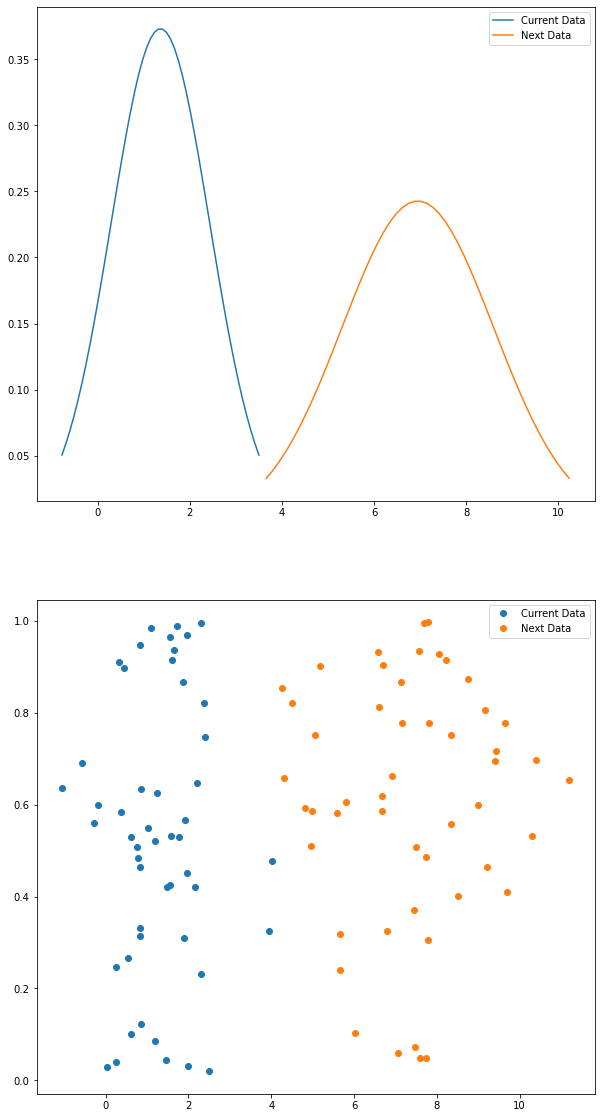

In [7]:
nrows = 2
ncols = 1
fig, axs = plt.subplots(figsize=(10*ncols, 10*nrows), ncols=ncols, nrows=nrows)
plot_gaus_dist(mock_dset.sample(True, 50), axs[0], label='Current Data')
plot_gaus_dist(mock_dset.sample(False, 50), axs[0], label='Next Data') 
plot_data(mock_dset.sample(True, 50), axs[1], label='Current Data')
plot_data(mock_dset.sample(False, 50), axs[1], label='Next Data') 

### Use Diffusion Model to Generate one of the Distributions
First step is to generate one of the distributions (let's say `curr_z` only for now)

In [8]:
# Initialize the models
device = torch.device('cuda:0')
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-5
EPOCHS = 60
N_SAMPLES = 100 # Number of values to sample when we sample from diffusion
N_STEPS = 500
eps_model = EpsModel(4,16,1).to(device) # Input shape: 1 for number 1 for timestep of the noise
diffusion = DenoiseDiffusion(
    eps_model=eps_model,
    n_steps=N_STEPS, # Number of steps to noise the data
    device=device # This model should be able to be trained on CPU
)
optimizer = torch.optim.Adam(params=eps_model.parameters(),
                             lr=LEARNING_RATE,
                             weight_decay=WEIGHT_DECAY)


In [9]:
# Initialize the dataset and the dataloader
dataloader = data.DataLoader(mock_dset, batch_size=32, shuffle=True, num_workers=4)

Epoch: 59, Loss: 3.313668226636946e-07: 100%|██████████| 60/60 [01:17<00:00,  1.29s/it] 


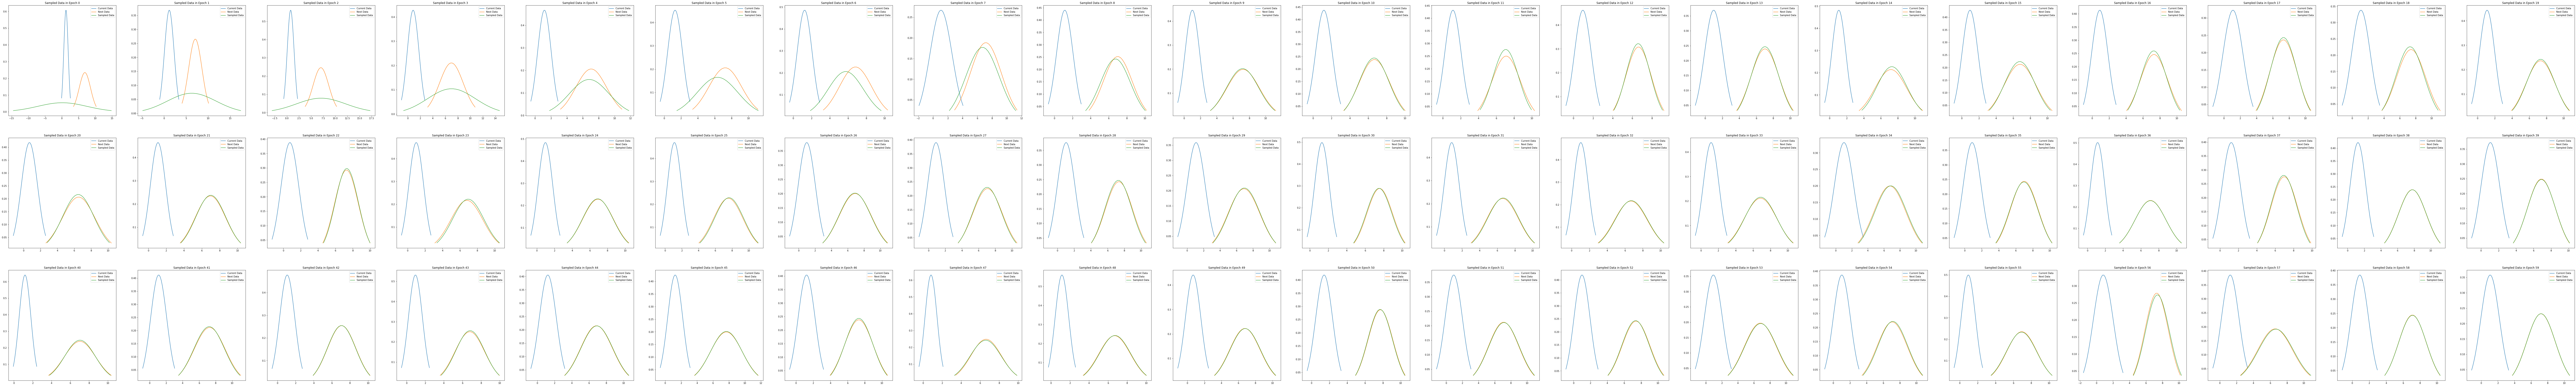

In [10]:
total_losses = []
diff_losses = []
mse_losses = [] # Losses bw sampled next state and actual next state

# eval_step = 5 # Evaluate once in every 5 training steps
# total_plot_num = EPOCHS * math.ceil(len(dataloader)/5)
ncols = 20
nrows = math.ceil(EPOCHS / ncols)
fig, axs = plt.subplots(figsize=(10*ncols, 10*nrows), nrows=nrows, ncols=ncols)
pbar = tqdm(total=EPOCHS)

for i in range(EPOCHS):
    axs_row = int(i / ncols)
    axs_col = int(i % ncols)

    epoch_total_loss = 0
    # epoch_diff_loss = 0
    # epoch_mse_loss = 0
    for j,batch in enumerate(dataloader):
        optimizer.zero_grad()
        x0, xnext0, a = [b.to(device) for b in batch]
        loss = diffusion.loss(x0, xnext0, a)

        total_loss = loss # TODO: Check this out 
        total_loss.backward()
        optimizer.step()
        epoch_total_loss += total_loss.item()
        
    avg_loss = epoch_total_loss/len(mock_dset)
    total_losses.append(avg_loss)

    pbar.set_description(f'Epoch: {i}, Loss: {avg_loss/len(mock_dset)}')
    pbar.update(1)

    # Sample data from learned distribution - it should get closer and closer to the curr_z distribution
    # Get a random batch
    batch = next(iter(dataloader))
    x0, xnext0, a = [b.to(device) for b in batch]
    xt = torch.randn((x0.shape), device=x0.device)
    for t_ in range(N_STEPS):
        curr_t = N_STEPS - t_ - 1
        t = xt.new_full((xt.shape[0],), curr_t, dtype=torch.long)
        xt = diffusion.p_sample(xt, t, x0, a)

    axs[axs_row, axs_col].set_title("Sampled Data in Epoch {}".format(i))
    plot_gaus_dist(x0[:,0].cpu().detach().numpy(), axs[axs_row, axs_col], label='Current Data') 
    plot_gaus_dist(xnext0[:,0].cpu().detach().numpy(), axs[axs_row, axs_col], label='Next Data')
    plot_gaus_dist(xt[:,0].cpu().detach().numpy(), axs[axs_row, axs_col], label='Sampled Data')


pbar.close() 

In [11]:
pbar.close()

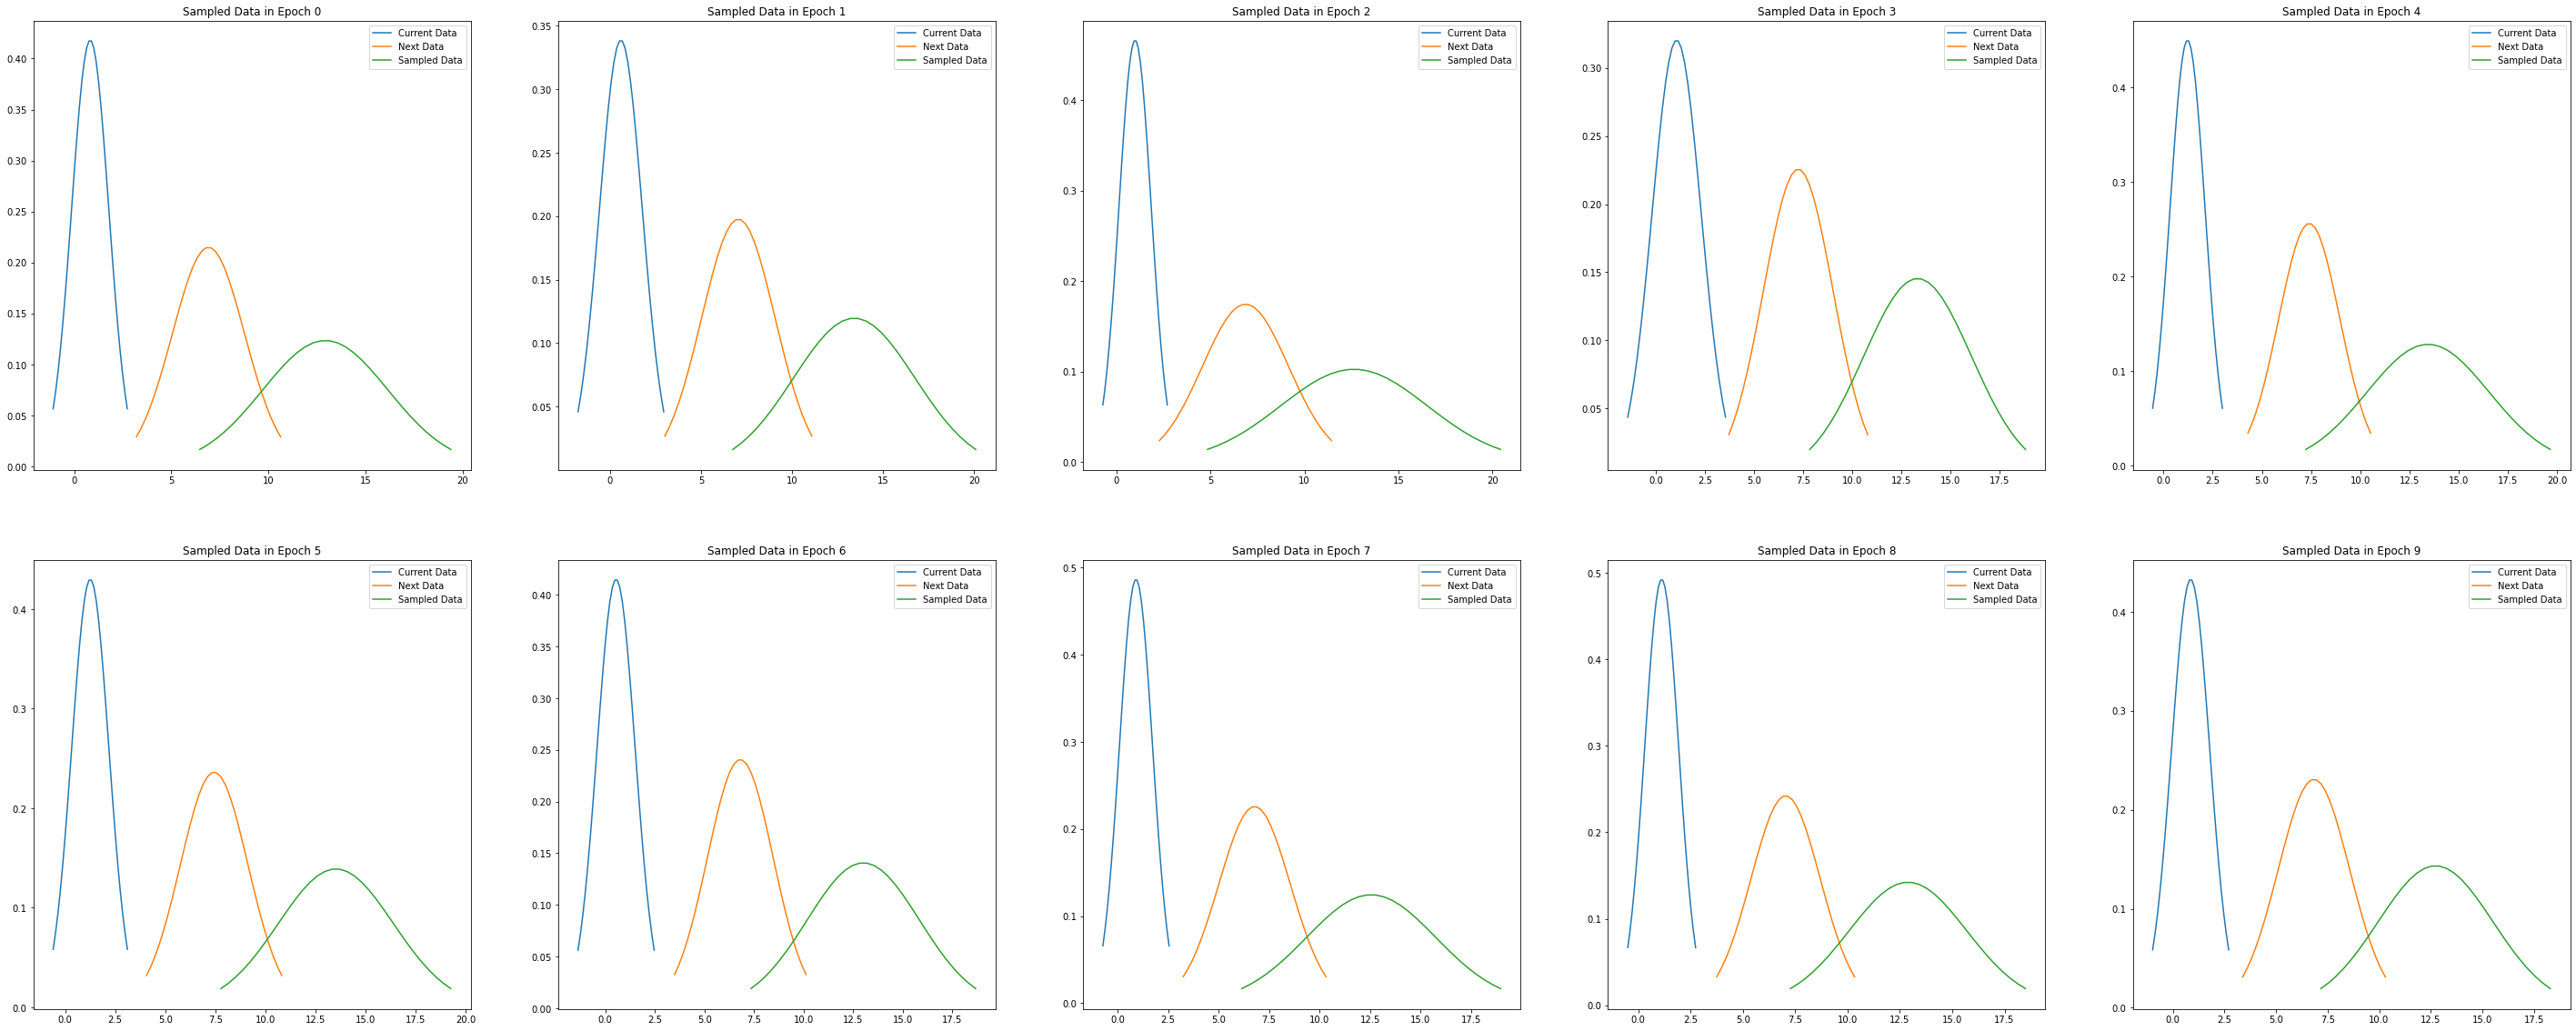

In [20]:
# Evaluate model
ncols = 5
nrows = math.ceil(10 / ncols)
fig, axs = plt.subplots(figsize=(10*ncols, 10*nrows), nrows=nrows, ncols=ncols)
for i in range(10):
    axs_row = int(i / ncols)
    axs_col = int(i % ncols)
   # Sample data from learned distribution - it should get closer and closer to the curr_z distribution
    # Get a random batch
    batch = next(iter(dataloader))
    x0, xnext0, a = [b.to(device) for b in batch]
    xt = torch.randn((x0.shape), device=x0.device)
    for t_ in range(N_STEPS):
        curr_t = N_STEPS - t_ - 1
        t = xt.new_full((xt.shape[0],), curr_t, dtype=torch.long)
        xt = diffusion.p_sample(xt, t, xnext0, a)

    axs[axs_row, axs_col].set_title("Sampled Data in Epoch {}".format(i))
    plot_gaus_dist(x0[:,0].cpu().detach().numpy(), axs[axs_row, axs_col], label='Current Data') 
    plot_gaus_dist(xnext0[:,0].cpu().detach().numpy(), axs[axs_row, axs_col], label='Next Data')
    plot_gaus_dist(xt[:,0].cpu().detach().numpy(), axs[axs_row, axs_col], label='Sampled Data')

In [ ]:
pbar.close()

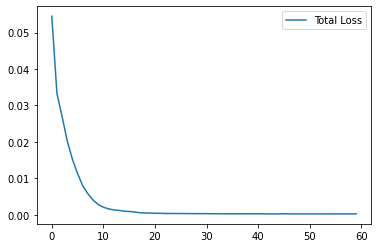

In [ ]:
plt.plot(total_losses, label="Total Loss")
# plt.plot(mse_losses, label="MSE Loss")
# plt.plot(diff_losses, label="Diffusion Loss")
plt.legend()

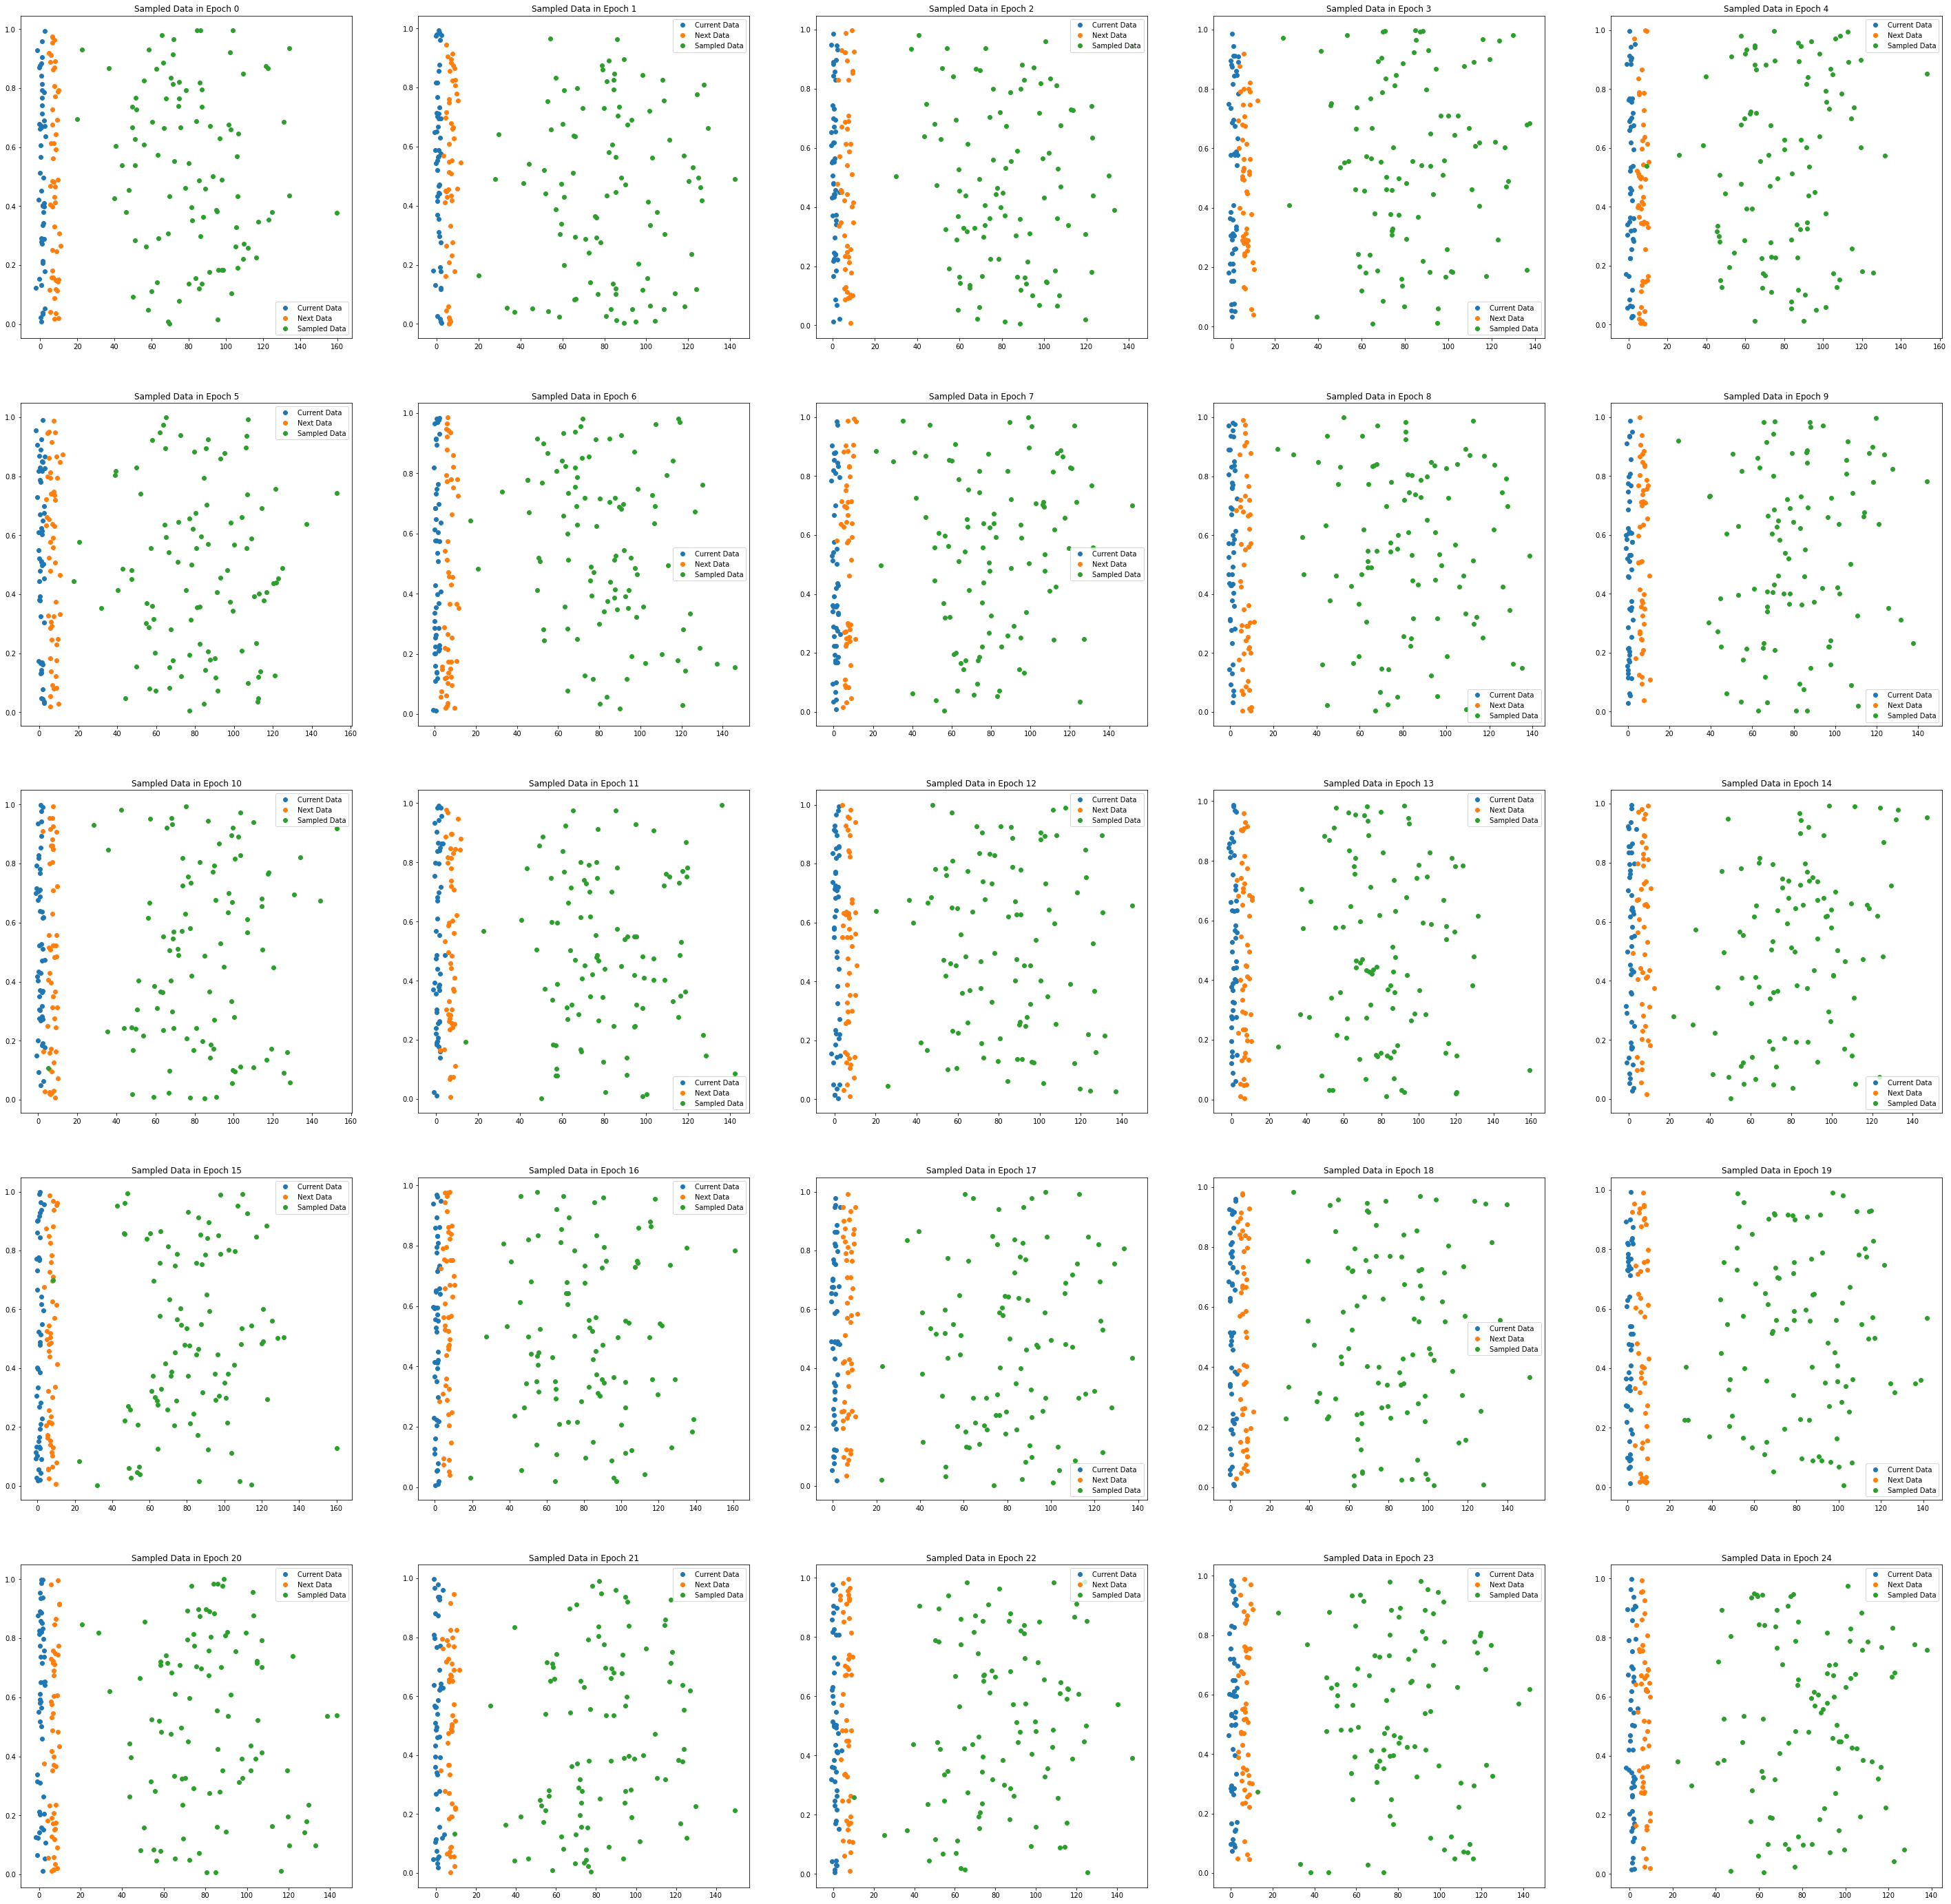

In [ ]:
ncols = 5
nrows = 5
fig, axs = plt.subplots(figsize=(10*ncols, 10*nrows), nrows=nrows, ncols=ncols)
for i in range(25):
    axs_row = int(i / ncols)
    axs_col = int(i % ncols)
    
    x = torch.randn((N_SAMPLES, 1), device=device)
    for t_ in range(N_STEPS):
        t = N_STEPS - t_ - 1
        x = diffusion.p_sample(x, x.new_full((N_SAMPLES,), t, dtype=torch.long), 10*a)

    # print('curr_z_dset.data.shape: {}'.format(curr_z_dset.data.shape))
    # print('x.shape: {}'.format(x.shape))
    axs[axs_row, axs_col].set_title("Sampled Data in Epoch {}".format(i))
    plot_data(mock_dset.sample(True, 50), axs[axs_row, axs_col], label='Current Data') 
    plot_data(mock_dset.sample(False, 50), axs[axs_row, axs_col], label='Next Data') 
    plot_data(x[:,0].cpu().detach().numpy(), axs[axs_row, axs_col], label='Sampled Data')